# 扩散模型

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class SimpleUNet(nn.Module):
    """简单的U-Net结构作为去噪网络"""
    def __init__(self, in_channels=3):
        super().__init__()
        # 编码器
        self.enc1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1, stride=2)
        
        # 解码器
        self.dec3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.dec1 = nn.Conv2d(128, in_channels, 3, padding=1)
        
    def forward(self, x, time_emb):
        # 编码过程
        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(e1))
        e3 = F.relu(self.enc3(e2))
        
        # 解码过程(使用跳跃连接)
        d3 = F.relu(self.dec3(e3))
        d2 = F.relu(self.dec2(torch.cat([d3, e2], dim=1)))
        d1 = self.dec1(torch.cat([d2, e1], dim=1))
        return d1

class DiffusionModel:
    """扩散模型主类"""
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        # 定义噪声调度
        self.beta = torch.linspace(1e-4, 0.02, timesteps)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
        # 初始化去噪网络
        self.denoise_model = SimpleUNet()
        
    def time_embedding(self, timesteps, dim=256):
        """生成时间步的嵌入向量"""
        half = dim // 2
        freqs = torch.exp(
            -torch.log(torch.tensor(10000.0)) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        )
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        return embedding

    def add_noise(self, x_0, t):
        """给图像添加噪声"""
        eps = torch.randn_like(x_0)
        alpha_bar_t = self.alpha_bar[t]
        noisy = torch.sqrt(alpha_bar_t)[:, None, None, None] * x_0 + \
                torch.sqrt(1 - alpha_bar_t)[:, None, None, None] * eps
        return noisy, eps
    
    def remove_noise(self, x_t, t):
        """去除噪声"""
        time_emb = self.time_embedding(t)
        predicted_noise = self.denoise_model(x_t, time_emb)
        
        alpha_t = self.alpha[t]
        alpha_bar_t = self.alpha_bar[t]
        beta_t = self.beta[t]
        
        # 计算去噪后的图像
        factor = 1 / torch.sqrt(alpha_t)
        noise_factor = beta_t / torch.sqrt(1 - alpha_bar_t)
        x_0 = factor * (x_t - noise_factor * predicted_noise)
        
        return x_0

    def sample(self, batch_size=1, img_size=32):
        """生成图像采样过程"""
        # 从纯噪声开始
        x = torch.randn(batch_size, 3, img_size, img_size)
        
        # 逐步去噪
        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((batch_size,), t, dtype=torch.long)
            x = self.remove_noise(x, t_batch)
            
            # 添加一些随机噪声以增加多样性
            if t > 0:
                noise = torch.randn_like(x)
                x = x + torch.sqrt(self.beta[t]) * noise
        
        return x

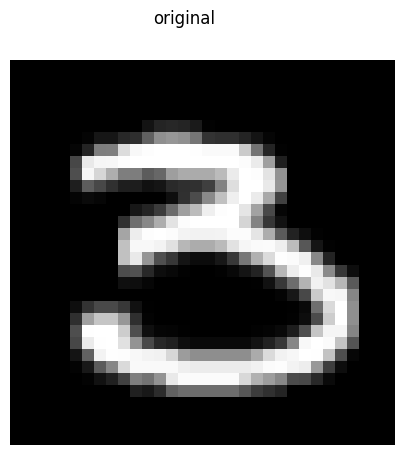

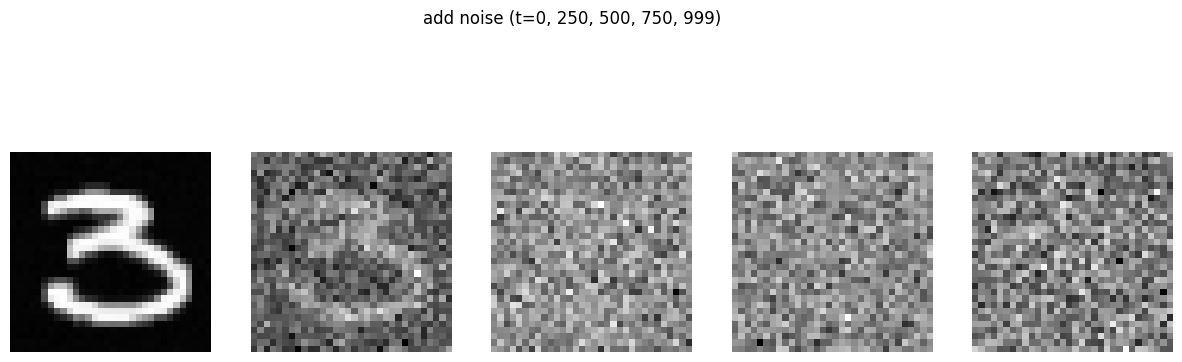

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


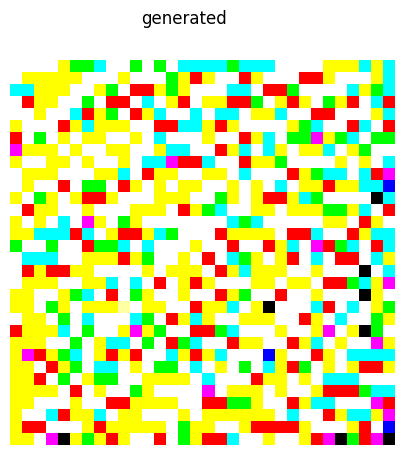

In [5]:
def load_mnist_data():
    """加载MNIST数据集作为示例"""
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = datasets.MNIST(root='./data', train=True, 
                           download=True, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=True)

def show_images(images, title):
    """显示图像"""
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    
    # 调整维度顺序和归一化
    images = np.transpose(images, (0, 2, 3, 1))
    images = (images + 1) / 2.0  # 从[-1,1]转换到[0,1]
    
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]
    
    for ax, img in zip(axes, images):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.suptitle(title)
    plt.show()

def main():
    # 创建模型实例
    diffusion = DiffusionModel(timesteps=1000)
    
    # 加载一批真实图像
    dataloader = load_mnist_data()
    real_images, _ = next(iter(dataloader))
    
    # 展示原始图像
    show_images(real_images, "original")
    
    # 演示不同时间步的加噪过程
    time_steps = [0, 250, 500, 750, 999]
    noisy_images = []
    
    for t in time_steps:
        t_tensor = torch.tensor([t])
        noisy_image, _ = diffusion.add_noise(real_images, t_tensor)
        noisy_images.append(noisy_image)
    
    # 展示加噪过程
    show_images(torch.cat(noisy_images, dim=0), 
               f"add noise (t={', '.join(map(str, time_steps))})")
    
    # 生成图像采样过程
    generated_image = diffusion.sample(batch_size=1, img_size=32)
    
    # 展示生成的图像
    show_images(generated_image, "generated")

if __name__ == "__main__":
    main()